In [1]:
#Parameter Optimization


[*********************100%%**********************]  2 of 2 completed


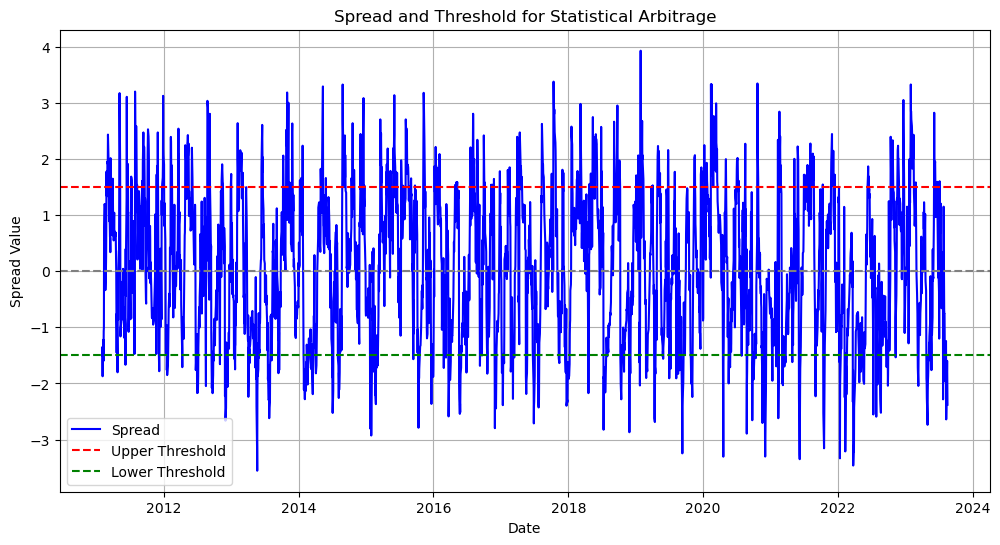

C:\Users\pradn\AppData\Local\Temp\ipykernel_19552\3170896342.py:43: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['Signal'].replace(to_replace=np.nan, method='ffill')


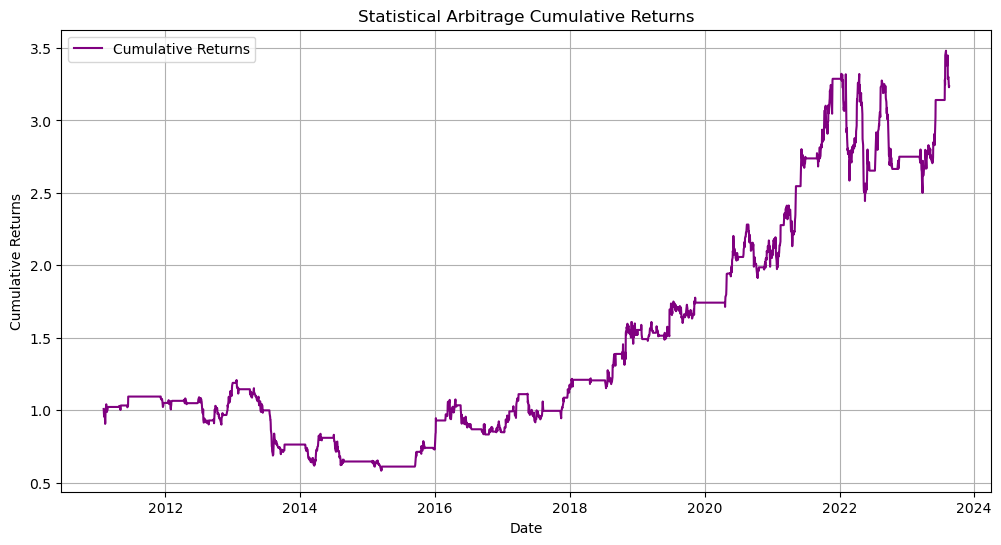

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pyfolio as pf

# Downloading the data of two stocks from Yahoo Finance
def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data
#A ratio spread (option) is a neutral strategy in which an investor simultaneously holds an unequal number of long and short or written options.
#Traders use a ratio strategy when they believe the price of the underlying asset won't move much
def calculate_spread(data, pair):
    spread = data[pair[0]]/data[pair[1]]
    return spread
# mean reverting strategy is realized by determining the normalized deviation of price from its moving average 
#(essentially, a moving Z-score of the last closing price) 
#The lookback period for the moving average and moving standard deviation is set equal to the half life of mean reversion
def calculate_zscore(spread, lookback):
    rolling_mean = spread.rolling(window=lookback).mean()
    rolling_std = spread.rolling(window=lookback).std()
    zscore = (spread - rolling_mean) / rolling_std
    return zscore

def plot_spread_and_threshold(spread, zscore, threshold):
    plt.figure(figsize=(12, 6))
    plt.plot(spread.index, zscore, label='Spread', color='blue')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axhline(threshold, color='red', linestyle='--', label='Upper Threshold')
    plt.axhline(-threshold, color='green', linestyle='--', label='Lower Threshold')
    plt.legend()
    plt.title('Spread and Threshold for Statistical Arbitrage')
    plt.xlabel('Date')
    plt.ylabel('Spread Value')
    plt.grid(True)
    plt.show()

def backtest_strategy(data, pair, zscore, threshold):
    data['zscore'] = zscore
    # Generate trading signals
    data['Signal'] = np.where(data['zscore'] < -threshold, 1, np.nan)
    data['Signal']= np.where(data['zscore'] > threshold, 0, data['Signal'])
    data['position'] = data['Signal'].replace(to_replace=np.nan, method='ffill')
    data['returns'] = data[pair[0]].pct_change() * data['position'].shift(1)
    cumulative_returns = (1 + data['returns']).cumprod()
    return cumulative_returns

if __name__ == "__main__":
    # Set your desired parameters
    tickers = ['TORNTPOWER.NS', 'ADANIPOWER.NS']  # Ticker symbols of the two stocks to be analyzed
    start_date = '2011-01-01'
    end_date = '2023-08-19'
    lookback = 20             # Rolling window for calculating z-score
    threshold = 1.5           # Threshold for triggering trading signals

    # Step 1: Download data from Yahoo Finance
    data = download_data(tickers, start_date, end_date)

    # Step 2: Calculate the spread between the two stocks
    spread = calculate_spread(data, tickers)

    # Step 3: Calculate the z-score of the spread
    zscore = calculate_zscore(spread, lookback)

    # Step 4: Plot the spread and threshold values
    plot_spread_and_threshold(spread, zscore, threshold)

    # Step 5: Backtest the strategy and calculate cumulative returns
    cumulative_returns = backtest_strategy(data, tickers, zscore, threshold)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, cumulative_returns, label='Cumulative Returns', color='purple')
    plt.legend()
    plt.title('Statistical Arbitrage Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.grid(True)
    plt.show()


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

def calculate_spread(data, pair):
    spread = data[pair[0]] - data[pair[1]]
    return spread

def calculate_zscore(spread, lookback):
    rolling_mean = spread.rolling(window=lookback).mean()
    rolling_std = spread.rolling(window=lookback).std()
    zscore = (spread - rolling_mean) / rolling_std
    return zscore

def backtest_strategy(data, pair, zscore, threshold, capital):
    data['zscore'] = zscore
    # Generate trading signals
    data['Signal'] = np.where(data['zscore'] < -threshold, 1, np.nan)
    data['Signal']= np.where(data['zscore'] > threshold, 0, data['Signal'])
    data['position'] = data['Signal'].replace(to_replace=np.nan, method='ffill')
    data['returns'] = data[pair[0]].pct_change() * data['position'].shift(1)
    data['cumulative_returns'] = (1 + data['returns']).cumprod()
    data['portfolio_value'] = capital * data['cumulative_returns']
    return data

def calculate_metrics(data, risk_free_rate=0.068781, trading_days_per_year=252):
    # Calculate daily returns and remove NaN values
    daily_returns = data['cumulative_returns'].pct_change().dropna()

    # Calculate performance metrics
    annual_return = (data['cumulative_returns'][-1]) ** (trading_days_per_year / len(data)) - 1
    annual_volatility = daily_returns.std() * np.sqrt(trading_days_per_year)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    max_drawdown = (data['portfolio_value'] / data['portfolio_value'].cummax()).min() - 1
    calmar_ratio = annual_return / abs(max_drawdown)

    daily_value_at_risk = -np.percentile(daily_returns, 5)  # 5% Value at Risk (VaR)
    omega_ratio = -annual_return / daily_value_at_risk
    sortino_ratio = (annual_return - risk_free_rate) / (daily_returns[daily_returns < 0].std() * np.sqrt(trading_days_per_year))
    tail_ratio = daily_returns[daily_returns < 0].mean() / daily_returns[daily_returns < 0].std()

    return annual_return, annual_volatility, sharpe_ratio, calmar_ratio, daily_value_at_risk, max_drawdown, omega_ratio, sortino_ratio, tail_ratio

if __name__ == "__main__":
    # Set your desired parameters
    tickers = ['TORNTPOWER.NS', 'ADANIGREEN.NS']  # Ticker symbols of the two stocks to be analyzed
    start_date = '2011-01-01'
    end_date = '2023-08-19'
    lookback = 20             # Rolling window for calculating z-score
    threshold = 1.5           # Threshold for triggering trading signals
    initial_capital = 100000  # Initial capital for backtesting

    # Step 1: Download data from Yahoo Finance
    data = download_data(tickers, start_date, end_date)

    # Step 2: Calculate the spread between the two stocks
    spread = calculate_spread(data, tickers)

    # Step 3: Calculate the z-score of the spread
    zscore = calculate_zscore(spread, lookback)

    # Step 4: Backtest the strategy and calculate cumulative returns
    backtest_data = backtest_strategy(data, tickers, zscore, threshold, initial_capital)

    # Step 5: Calculate performance metrics
    annual_return, annual_volatility, sharpe_ratio, calmar_ratio, daily_value_at_risk, max_drawdown, omega_ratio, sortino_ratio, tail_ratio = calculate_metrics(backtest_data)

    print(f"Annual Return: {annual_return:.2%}")
    print(f"Annual Volatility: {annual_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Calmar Ratio: {calmar_ratio:.2f}")
    print(f"Daily Value at Risk (VaR) (5%): {daily_value_at_risk:.2%}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Omega Ratio: {omega_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Tail Ratio: {tail_ratio:.2f}")


[*********************100%%**********************]  2 of 2 completed

Annual Return: 9.20%
Annual Volatility: 25.23%
Sharpe Ratio: 0.09
Calmar Ratio: 0.25
Daily Value at Risk (VaR) (5%): 2.24%
Max Drawdown: -37.37%
Omega Ratio: -4.10
Sortino Ratio: 0.12
Tail Ratio: -1.12



C:\Users\pradn\AppData\Local\Temp\tmpk8nq1nmu\ipykernel_19552\3711082233.py:26: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['position'] = data['Signal'].replace(to_replace=np.nan, method='ffill')
C:\Users\pradn\AppData\Local\Temp\tmpk8nq1nmu\ipykernel_19552\3711082233.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annual_return = (data['cumulative_returns'][-1]) ** (trading_days_per_year / len(data)) - 1


In [4]:
import yfinance as yf
import statsmodels.api as sm
import numpy as np
import pandas as pd

def fetch_data(stock1, stock2, start_date, end_date):
    stock1_data = yf.download(stock1, start=start_date, end=end_date)
    stock2_data = yf.download(stock2, start=start_date, end=end_date)
    return stock1_data['Close'], stock2_data['Close']

def is_cointegrated(ts1, ts2):
    A = ts1.values
    B = ts2.values
    A = sm.add_constant(A)
    result = sm.OLS(B, A).fit()
    b = result.params[1]
    spread = ts2 - b * ts1
    adf_result = adfuller(spread)
    p_value = adf_result[1]
    return p_value < 0.05, spread

def generate_signals(ts1, ts2, threshold=1):
    _, spread = is_cointegrated(ts1, ts2)
    z_score = (spread - spread.mean()) / spread.std()
    buy_signal = z_score < -threshold
    sell_signal = z_score > threshold
    exit_signal = abs(z_score) < 0.5
    return buy_signal, sell_signal, exit_signal


In [5]:
def backtest(ts1, ts2, buy_signal, sell_signal, exit_signal):
    initial_balance = 100000
    balance = initial_balance
    position = 0  # 1 for long, -1 for short, 0 for no position
    balances = []

    for i in range(len(ts1)):
        if buy_signal[i]:
            position = 1
        elif sell_signal[i]:
            position = -1
        elif exit_signal[i]:
            position = 0

        # Update balance based on position
        if position == 1:
            balance += ts1[i] - ts2[i]
        elif position == -1:
            balance -= ts1[i] - ts2[i]

        balances.append(balance)

    return balances

def calculate_metrics(balances):
    returns = pd.Series(balances).pct_change().dropna()
    annual_return = returns.mean() * 252
    annual_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    max_drawdown = np.max(np.maximum.accumulate(balances) - balances)
    calmar_ratio = annual_return / max_drawdown
    daily_var = np.percentile(returns, 5)
    omega_ratio = returns.mean() / daily_var
    sortino_ratio = annual_return / returns[returns < 0].std()
    tail_ratio = np.percentile(returns, 95) / np.abs(np.percentile(returns, 5))

    return {
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Calmar Ratio": calmar_ratio,
        "Daily VaR": daily_var,
        "Max Drawdown": max_drawdown,
        "Omega Ratio": omega_ratio,
        "Sortino Ratio": sortino_ratio,
        "Tail Ratio": tail_ratio
    }


In [6]:
#parameter optimization thru grid search
def optimize_parameters(ts1, ts2):
    best_metrics = {}
    for threshold in np.linspace(0.5, 2, 20):
        buy_signal, sell_signal, exit_signal = generate_signals(ts1, ts2, threshold)
        balances = backtest(ts1, ts2, buy_signal, sell_signal, exit_signal)
        metrics = calculate_metrics(balances)
        for metric, value in metrics.items():
            if metric not in best_metrics or value > best_metrics[metric][0]:
                best_metrics[metric] = (value, threshold)

    return best_metrics

ts1, ts2 = fetch_data('TORNTPOWER.NS', 'ADANIPOWER.NS', '2020-01-01', '2023-01-01')

#best_params = optimize_parameters(ts1, ts2)
#print(best_params)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
#Parameter Optimization on 10 stocks
import yfinance as yf
import statsmodels.api as sm
import numpy as np
import pandas as pd
from itertools import combinations

# List of 10 Indian stocks
stocks = ['RELIANCE.NS', 'TATAMOTORS.NS', 'INFY.NS', 'TCS.NS', 'ICICIBANK.NS', 'HDFCBANK.NS', 'ITC.NS', 'ONGC.NS', 'SUNPHARMA.NS', 'WIPRO.NS']

# Fetch data
def fetch_data(stocks, start_date, end_date):
    data = {}
    for stock in stocks:
        data[stock] = yf.download(stock, start=start_date, end=end_date)['Close']
    return pd.DataFrame(data)

# Check for cointegration
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            stock1 = data[keys[i]]
            stock2 = data[keys[j]]
            result = sm.tsa.stattools.coint(stock1, stock2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return pairs


In [8]:
def backtest_pair(data, stock1, stock2, threshold=1):
    ratio = data[stock1] / data[stock2]
    zscore = (ratio - ratio.mean()) / ratio.std()
    signals = pd.Series(index=data.index)
    signals[zscore > threshold] = -1
    signals[zscore < -threshold] = 1
    signals.fillna(0, inplace=True)
    returns = signals.shift(1) * (data[stock1].pct_change() - data[stock2].pct_change())
    return returns.cumsum()

def calculate_metrics(returns):
    annual_return = returns.mean() * 252
    annual_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility
    max_drawdown = np.max(np.maximum.accumulate(returns) - returns)
    calmar_ratio = annual_return / max_drawdown
    daily_var = np.percentile(returns, 5)
    omega_ratio = returns.mean() / daily_var
    sortino_ratio = annual_return / returns[returns < 0].std()
    tail_ratio = np.percentile(returns, 95) / np.abs(np.percentile(returns, 5))

    return {
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Calmar Ratio": calmar_ratio,
        "Daily VaR": daily_var,
        "Max Drawdown": max_drawdown,
        "Omega Ratio": omega_ratio,
        "Sortino Ratio": sortino_ratio,
        "Tail Ratio": tail_ratio
    }


In [9]:
def optimize_parameters(data, pairs):
    best_metrics = {}
    for pair in pairs:
        for threshold in np.linspace(0.5, 2, 20):
            returns = backtest_pair(data, pair[0], pair[1], threshold)
            metrics = calculate_metrics(returns)
            for metric, value in metrics.items():
                if metric not in best_metrics or value > best_metrics[metric][0]:
                    best_metrics[metric] = (value, pair, threshold)
    return best_metrics

data = fetch_data(stocks, '2020-01-01', '2021-01-01')
pairs = find_cointegrated_pairs(data)
best_params = optimize_parameters(data, pairs)
print(best_params)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'Annual Return': (256.894396847979, ('ITC.NS', 'ONGC.NS'), 0.5789473684210527), 'Annual Volatility': (8.529614017429434, ('ITC.NS', 'ONGC.NS'), 0.5789473684210527), 'Sharpe Ratio': (65.19648543698125, ('ITC.NS', 'ONGC.NS'), 1.8421052631578947), 'Calmar Ratio': (nan, ('INFY.NS', 'WIPRO.NS'), 0.5), 'Daily VaR': (nan, ('INFY.NS', 'WIPRO.NS'), 0.5), 'Max Drawdown': (nan, ('INFY.NS', 'WIPRO.NS'), 0.5), 'Omega Ratio': (nan, ('INFY.NS', 'WIPRO.NS'), 0.5), 'Sortino Ratio': (290549.2044684976, ('TCS.NS', 'WIPRO.NS'), 1.763157894736842), 'Tail Ratio': (nan, ('INFY.NS', 'WIPRO.NS'), 0.5)}


In [10]:
print(pairs)

[('INFY.NS', 'WIPRO.NS'), ('TCS.NS', 'WIPRO.NS'), ('ITC.NS', 'ONGC.NS')]
